In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/library_catalogue_20250427.csv')

In [3]:
#lol - remove in next iteration
df = df.rename(columns = {'Ficiton/non-fiction': 'Fiction / non-fiction'})

In [4]:
len(df)

638

## Data Cleaning

In [5]:
df = df.replace('na',np.nan)

Stripping, capitisling and removing apostrophes from text fields

In [6]:
strip_title_cols = ['Author', 'Publisher', 'Imprint Publisher', 'BookType', 
            'Primary Genre', 'Genres', 'Fiction / non-fiction', 'Series', 
            'Language', 'To/From', 'Unit Price']

for col in strip_title_cols:
    df[col] = df[col].str.replace("'", "")
    df[col] = df[col].str.strip()
    df[col] = df[col].str.title()

Remove currency and change datatype

In [7]:
df['Unit Price'].str[:1].value_counts(dropna=False)

Unit Price
£      486
NaN    152
Name: count, dtype: int64

In [8]:
df['Unit Price'] = df['Unit Price'].str[1:]
df['Unit Price'] = df['Unit Price'].astype(float)

Create Surname column for ordering

In [9]:
df['surname'] = [x.split(' ')[-1] for x in df['Author']]

Manual replacements by inspection

In [10]:
# Publisher
df.loc[df[df['Publisher'] == 'Random House'].index, 'Publisher'] = 'Penguin Random House'
df.loc[df[df['Publisher'] == 'Penguin Group'].index, 'Publisher'] = 'Penguin Random House'
df.loc[df[df['Publisher'] == 'Penguin'].index, 'Publisher'] = 'Penguin Random House'
df.loc[df[df['Publisher'] == 'Penguin Books'].index, 'Publisher'] = 'Penguin Random House'

df.loc[df[df['Publisher'] == 'Scholastic Childrens Books'].index, 'Publisher'] = 'Scholastic'

df.loc[df[df['Publisher'] == 'Pan'].index, 'Publisher'] = 'Pan Macmillan'
df.loc[df[df['Publisher'] == 'Macmillan And Co'].index, 'Publisher'] = 'Pan Macmillan'

# Fiction / Non-fiction
df.loc[df[df['Fiction / non-fiction'] == 'Poetry'].index, 'Fiction / non-fiction'] = 'Fiction'
df.loc[df[df['Fiction / non-fiction'] == 'Ficion'].index, 'Fiction / non-fiction'] = 'Fiction'

# BookType
df.loc[df[df['BookType'] == 'Paperback With Flaps'].index, 'BookType'] = 'Paperback'

# Series
df.loc[df[df['Series'] == '0'].index, 'Series'] = np.nan
df.loc[df[df['Series'] == 'Acotar'].index, 'Series'] = 'A Court Of Thorns And Roses'
df.loc[df[df['Series'] == 'Fourth Wing Proofs'].index, 'Series'] = 'The Empyrean'
df.loc[df[df['Series'] == 'The Empyrean Series'].index, 'Series'] = 'The Empyrean'

# Volume
df.loc[df[df['Volume'] == 'The Scribe Quadrant'].index, 'Volume'] = '1'
df.loc[df[df['Volume'] == 'The Infantry Quadrant'].index, 'Volume'] = '1'

# Author
df.loc[df[df['Author'] == 'George R R Martin'].index, 'Author'] = 'George R.R Martin'


Buckets

In [11]:
# Page Number
df['Page number'] = df['Page number'].fillna(0).astype(int)
df.loc[df.query("`Page number` < 100").index, 'page_number_group'] = '<100'
df.loc[df.query("`Page number` < 200 and `Page number` > 99").index, 'page_number_group'] = '100-200'
df.loc[df.query("`Page number`< 300 and `Page number` > 199").index, 'page_number_group'] = '200-300'
df.loc[df.query("`Page number` < 400 and `Page number` > 299").index, 'page_number_group'] = '300-400'
df.loc[df.query("`Page number` < 500 and `Page number` > 399").index, 'page_number_group'] = '400-500'
df.loc[df.query("`Page number` < 600 and `Page number` > 499").index, 'page_number_group'] = '500-600'
df.loc[df.query("`Page number` > 599").index, 'page_number_group'] = '600+'

# Price
df.loc[df.query("`Unit Price` < 8").index, 'price'] = '<£8'
df.loc[df.query("`Unit Price` < 10 and `Unit Price` > 7").index, 'price'] = '£8-£10'
df.loc[df.query("`Unit Price` < 12 and `Unit Price` > 9").index, 'price'] = '£10-£12'
df.loc[df.query("`Unit Price` > 11").index, 'price'] = '£12+'

In [15]:
df.to_csv('data/cleaned_bookshelf_27042025.csv')

Ordering

In [14]:
legacy_order = ['Modern & Contemporary Fiction', 'Short Stories', 'Crime & Mystery', 
                            'Romance', 'Classic Fiction', 'Literary Essays', 'Poetry',
                            'Fantasy', 'Science Fiction', 'Young Adult', "Childrens & Teenage",
                            'Historical Fiction', 'Myths & Legends', 
                            'Popular Science', 'Academic','Sociology', 'Philosophy', 'History', 'Feminist Theory', 'Memoirs',
                            'Gifts', 'Travel & Holiday Guides', 'Careers', 'Diy', 'Cookery']

df['Primary Genre numerical'] = df['Primary Genre']
for i, genre in enumerate(legacy_order):
    df['Primary Genre numerical'] = df['Primary Genre numerical'].str.replace(genre, str(i))
df['Primary Genre numerical'] = df['Primary Genre numerical'].astype(int)
    
book_order = df.sort_values(['Fiction / non-fiction', 'Primary Genre numerical', 'surname'])[['Name', 'Author', 'Fiction / non-fiction', 'Primary Genre']].reset_index(drop=True)
book_order.to_csv('bookshelf_order_250427.csv',index=False)

## Analytics

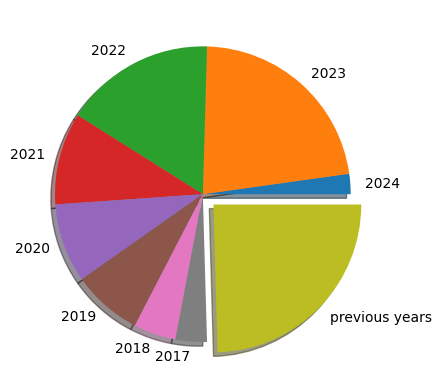

In [77]:
pub_year_years = list(df['Pub Year'].value_counts().keys())
pub_year_counts = list(df['Pub Year'].value_counts().values)

pub_year_df = pd.DataFrame({
    'pub_year': pub_year_years,
    'frequency': pub_year_counts
}).sort_values('pub_year', ascending=False).reset_index(drop=True)

pub_year_df['pub_year'] = pub_year_df['pub_year'].astype(int)
pub_year_df['pseudo_pub_year'] = pub_year_df['pub_year']
pub_year_df.loc[pub_year_df.query("pub_year < 2017").index, 'pseudo_pub_year'] = 2016

pub_year_df = pub_year_df.groupby(['pseudo_pub_year'])['frequency'].sum().reset_index(drop=False).sort_values('pseudo_pub_year', ascending=False)
pub_year_df['pseudo_pub_year'] = pub_year_df['pseudo_pub_year'].replace(2016, 'previous years')
plt.pie(pub_year_df['frequency'], labels = pub_year_df['pseudo_pub_year'], shadow=True, explode = [0,0,0,0,0,0,0,0,0.1]);

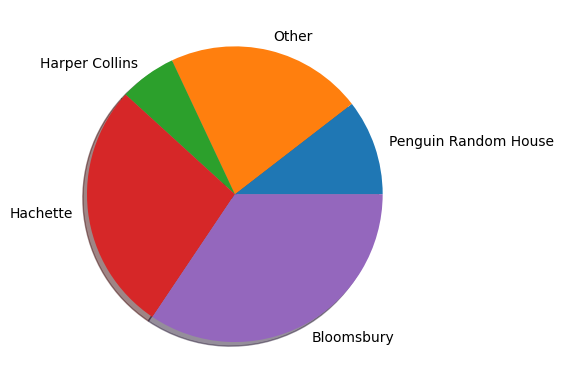

In [70]:
pub_year_years = list(df['Publisher'].value_counts().keys())
pub_year_counts = list(df['Publisher'].value_counts().values)

pub_year_df = pd.DataFrame({
    'Publisher': pub_year_years,
    'frequency': pub_year_counts
}).sort_values('Publisher', ascending=False).reset_index(drop=True)

pub_year_df['pseudo_Publisher'] = pub_year_df['Publisher']
pub_year_df = pub_year_df.sort_values('frequency', ascending = False).reset_index(drop=True)
pub_year_df.loc[np.arange(4, len(pub_year_df)), 'pseudo_Publisher'] = 'Other'

pub_year_df = pub_year_df.groupby(['pseudo_Publisher'])['frequency'].sum().reset_index(drop=False).sort_values('pseudo_Publisher', ascending=False)
plt.pie(pub_year_df['frequency'], labels = pub_year_df['pseudo_Publisher'], shadow=True);

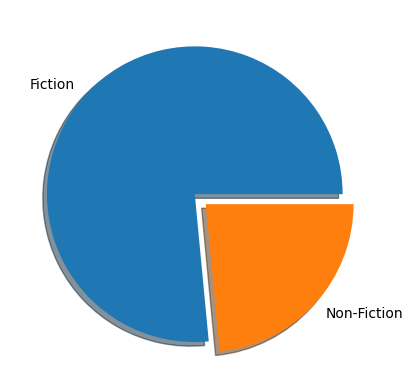

In [71]:
fic_nonfic = df.groupby('Fiction / non-fiction').size().reset_index(drop=False)
fic_nonfic.columns = ['fiction', 'frequency']
plt.pie(fic_nonfic['frequency'], labels = fic_nonfic['fiction'], explode = [0,0.1], shadow=True);

In [64]:
PageN = df.groupby('page_number_group').size().reset_index(drop=False)
PageN.columns = ['PageN', 'frequency']
plt.pie(PageN['frequency'], labels = PageN['PageN'], shadow=True);
plt.title('Length of books');

<BarContainer object of 25 artists>

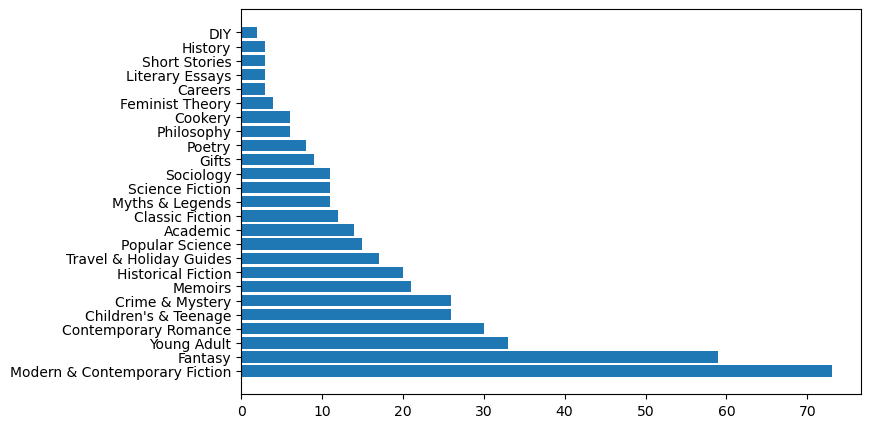

In [ ]:
prim_gen = df.groupby(['Primary Genre']).size().reset_index(drop=False)
prim_gen.columns = ['genre', 'frequency']
plt.figure(figsize = (8,5))
plt.barh(prim_gen.sort_values('frequency', ascending=False).genre, prim_gen.sort_values('frequency', ascending=False).frequency)

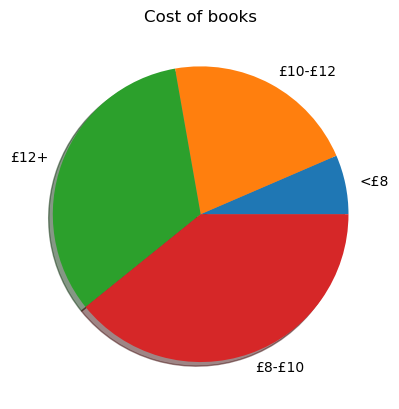

In [ ]:
price_df = df.groupby('price').size().reset_index(drop=False)
price_df.columns = ['price', 'frequency']
plt.pie(price_df['frequency'], labels = price_df['price'], shadow=True);
plt.title('Cost of books');

<BarContainer object of 6 artists>

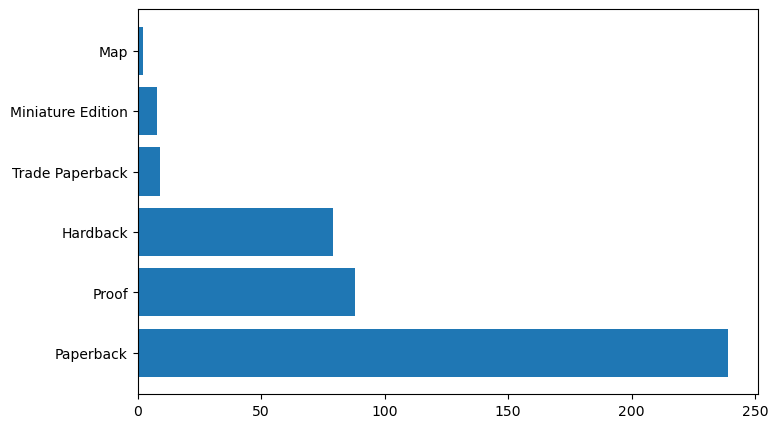

In [ ]:
df['BookType'] = df['BookType'].str.replace("Paperback With Flaps", "Paperback").replace("Flexiback", "Paperback").replace("Butchered Hardback", "Hardback")

booktype_df_keys = list(df['BookType'].value_counts().keys())
booktype_df_vals = list(df['BookType'].value_counts().values)

booktype_df = pd.DataFrame({
    'BookType': booktype_df_keys,
    'frequency': booktype_df_vals
}).sort_values('BookType', ascending=False).reset_index(drop=True)
plt.figure(figsize = (8,5))
plt.barh(booktype_df.sort_values('frequency', ascending=False).BookType, booktype_df.sort_values('frequency', ascending=False).frequency)

In [ ]:
author_df = df.groupby(['Author'])['QTY'].sum().reset_index(drop=False)
author_df.columns = ['Author', 'frequency']
author_df.sort_values('frequency', ascending = False)[0:10].to_csv('artefacts/top_10_author_presence.csv', index=False)

([<matplotlib.patches.Wedge at 0x141dd4250>,
 [Text(1.0973419685021264, 0.07642384551878027, '2024'),
  Text(0.733629079883011, 0.8196269719512695, '2023'),
  Text(-0.5175780313396743, 0.9706250467995081, '2022'),
  Text(-1.066743386758787, 0.2684372306636936, '2021'),
  Text(-1.0365375850821563, -0.36822524996535966, '2020'),
  Text(-0.7232087165490253, -0.8288360225687055, '2019'),
  Text(-0.35838088414027447, -1.0399822796003955, '2018'),
  Text(-0.08682530699915757, -1.09656799427327, '2017'),
  Text(0.8605100841914732, -0.8363745542547213, 'previous years')])

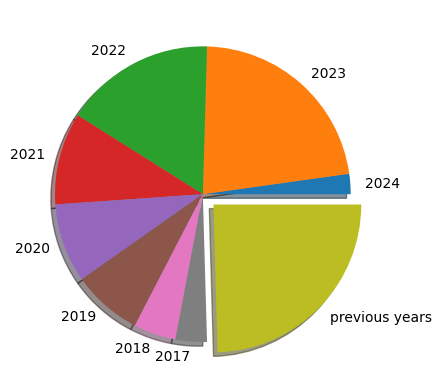

In [80]:
plt.pie(pub_year_df['frequency'], 
        labels = pub_year_df['pseudo_pub_year'], 
        shadow=True, 
        explode = [0,0,0,0,0,0,0,0,0.1]
        )